In [ ]:
Contains code for plotting a histogam of directional firing ranges of LMN, DTN and conj cells

In [1]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats

sim.ResetKernel()

mins = 3.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

simulation length: 3.0 mins = 180000 ms


## Params

In [2]:
N_ex = 180
N_in = N_ex
N_cj = N_ex

sigma = 0.12
mu = 0.5
delay = 0.1
base_ex = 4000 #*N_ex
base_in = 450 #*N_in
base_cj = 169
w_ex_cj = 660

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = N_ex//2

## Create populations

In [3]:
exc = sim.Create("iaf_psc_alpha",N_ex, params={"I_e": 450.})
inh = sim.Create("iaf_psc_alpha",N_in)

l = sim.Create("iaf_psc_alpha",N_cj)
r = sim.Create("iaf_psc_alpha",N_cj)

## Define connections

In [4]:
w_ex = np.empty((N_in,N_ex))
w_in = np.empty((N_ex,N_in))
for e in range(N_ex):
    for i in range(N_in):
        d1 = abs(e/N_ex - i/N_in)
        d2 = abs(e/N_ex - i/N_in -1)
        d3 = abs(e/N_ex - i/N_in +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_gauss = np.exp(-(d)**2/2/sigma**2)
        w_ring = np.exp(-(d - mu)**2/2/sigma**2)
        w_ex[i,e] = base_ex * w_gauss
        w_in[e,i] = base_in * w_ring 
            
w_ex[w_ex<10]=0
w_in[w_in<10]=0

In [5]:
w_l = np.empty((N_ex,N_cj))
w_r = np.empty((N_ex,N_cj))
for c in range(N_cj):  
    for e in range(N_ex):
        d1 = abs((e-1)/N_cj - c/N_ex)
        d2 = abs((e-1)/N_cj - c/N_ex -1)
        d3 = abs((e-1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_l[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
        d1 = abs((e+1)/N_cj - c/N_ex)
        d2 = abs((e+1)/N_cj - c/N_ex -1)
        d3 = abs((e+1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_r[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0

In [6]:
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_r = sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

l_2_exc = sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})

## Record spike activity

In [7]:
exc_spikes = sim.Create("spike_detector", N_ex, params={"withgid": True,"withtime": True})
sim.Connect(exc,exc_spikes)
inh_spikes = sim.Create("spike_detector", N_ex, params={"withgid": True,"withtime": True})
sim.Connect(inh,inh_spikes)
conj_spikes = sim.Create("spike_detector", N_ex, params={"withgid": True,"withtime": True})
sim.Connect(l,conj_spikes)

## Network input

### Odometry

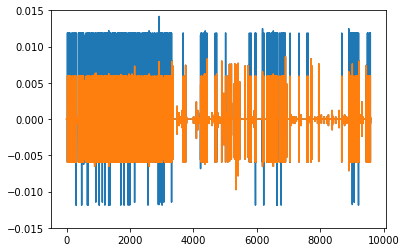

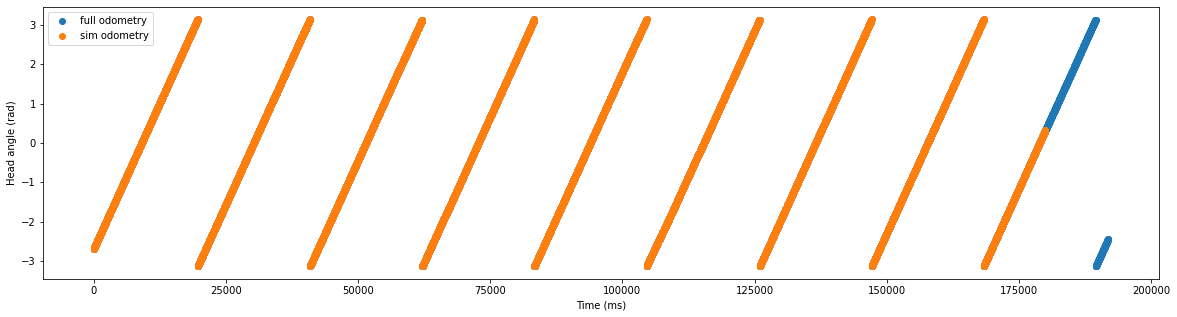

In [8]:
file = 'training_set'
posedata = pandas.read_csv(f'data/{file}.csv')

f = 50 #Hz
dt = int(1000/f)
theta = posedata['field.theta']

angle_per_cell = (2*np.pi)/N_ex
I_init_pos = np.around((theta[0]//angle_per_cell)+(N_ex//2)).astype(int)

t = list(range(0,(len(theta)*dt),dt))
time = [i*1. for i in t if i < sim_len]
t = [i * 1. for i in t]

vel = np.diff(np.unwrap(theta))

# check if velocity change is too hight then assume velocity at t = velocity at t-1
acc = np.diff(vel)
plt.plot(acc)
for i,a in enumerate(acc):
    if a > 0.01 or a < -0.01:
        vel[i] = vel[i-1]
acc = np.diff(vel)
plt.plot(acc)
plt.ylim([-0.015,0.015])
    
plt.figure(figsize=(20,5))
plt.scatter(t,theta,label='full odometry')
plt.scatter(time,theta[:len(time)],label='sim odometry')
plt.ylabel('Head angle (rad)')
plt.xlabel('Time (ms)')
plt.legend()

In [9]:
Ivel = vel * 0.35 * 10000

sh = 150
go_l,go_r = Ivel,-Ivel
go_l = go_l+sh
go_r = go_r+sh
go_l[go_l<=sh] = 0
go_r[go_r<=sh] = 0

# Connect AV input to conjunctive layers
l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})

sim.Connect(r_input,r,'all_to_all')
sim.Connect(l_input,l,'all_to_all')


## Initialize bump

In [10]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[I_init_pos]])

## Run simulation

In [11]:
tic = tm.time()
sim.Simulate(sim_len)
print(f'Simulation run time: {np.around(tm.time()-tic,2)} s  Simulated time: {np.around(sim_len/1000,2)} s')

Simulation run time: 219.86 s  Simulated time: 180.0 s


In [12]:
# fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20, 5),facecolor='w')

# ev = sim.GetStatus(exc_spikes)[0]['events']
# t = ev['times']
# sp = ev['senders']
# ax1.plot(t,sp,'.')
# ax1.set_ylabel('Neuron')
# ax1.set_xlabel('Time (ms)')
# ax1.set_xlim([0,sim_len])
# ax1.set_ylim([0,N_ex])

# ax2.plot(time,theta[:len(time)],'.',label='odometry')
# ax2.set_xlim([0,sim_len])
# ax2.set_ylim([-np.pi,np.pi])
# ax2.set_ylabel('Head angle (rad)')
# ax2.set_xlabel('Time (ms)')
# plt.legend()

## Measure error

In [13]:
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

dt = 20
T = np.arange(0,(len(theta)*dt),dt*2)

modes = np.zeros(len(T))
modes[:] = np.nan
rates = np.zeros((N_ex,len(time)))
for i in range(len(T)-1):
    idx = (t>T[i])*(t<T[i+1])
    lst = sp[np.where(idx)]
    occurence_count = Counter(lst) 
    active = occurence_count.keys()
    for cell in active:
        rates[cell-1,i] = occurence_count[cell]
    mode = occurence_count.most_common(1)
    if len(mode):
        modes[i] = mode[0][0]
        
step = (2*np.pi)/N_ex
modes = (modes*step) - np.pi

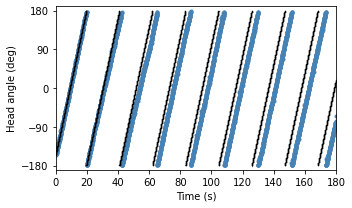

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(5, 3),facecolor='w')
# fig, ax = plt.subplots(1, 1,figsize=(8, 3),facecolor='w')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Head angle (deg)')

ax.plot(np.array(T)/1000,modes*(180/np.pi),'.',label='estimate',color='steelblue')
ax.plot(np.array(time)/1000,(theta[:len(time)])*(180/np.pi),'.',markersize=.5,label='ground truth',color='black')

plt.xlim([0,sim_len/1000])
plt.yticks([-180,-90,0,90,180])
plt.ylim([-190,190])
plt.tight_layout()
plt.savefig(f'rotating_drift',format='svg')

In [15]:
# stms = np.array(time[:len(theta)])
# threshold_crossings = np.diff(theta > theta[0], prepend=False)
# idx = np.argwhere(threshold_crossings)[:,0]
# loopidx = idx[range(0,len(idx),2)]
# loopidx = loopidx[:-2]
# loop = theta[loopidx]
# looptms = stms[loopidx]

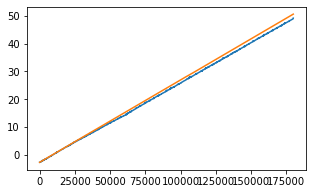

In [47]:
nanidx = np.where(~np.isnan(modes[:-1]))
modes = modes[nanidx]
T=T[nanidx]

est = np.unwrap(modes)
groundTruth = np.unwrap(theta[:len(time)])

estimate = np.interp(time, T, est)

fig, ax = plt.subplots(1, 1,figsize=(5, 3),facecolor='w')
ax.plot(time,estimate)
ax.plot(time,groundTruth)


hd_estimate = np.vstack([T,modes])
np.save(f'{file}_ideo_estimate.npy',hd_estimate)

In [17]:
# scipy.stats.pearsonr(estimate, groundTruth)

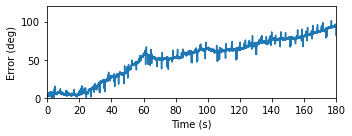

In [50]:
fig, ax = plt.subplots(1, 1,figsize=(5, 2),facecolor='w')

d = (groundTruth-estimate)
plt.plot(np.array(time)/1000,abs(d)*(180/np.pi))
plt.xlabel('Time (s)')
plt.ylabel('Error (deg)')
plt.xlim([0,sim_len/1000])
plt.ylim([0,120])
plt.tight_layout()
plt.tight_layout()
plt.savefig(f'rotating_error',format='svg')

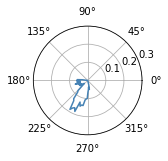

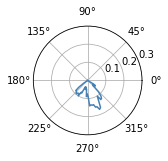

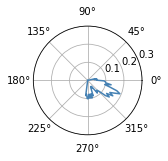

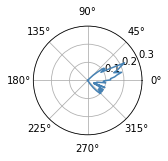

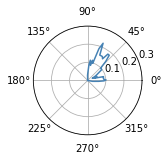

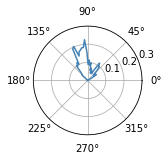

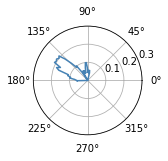

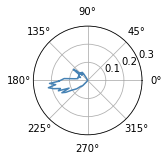

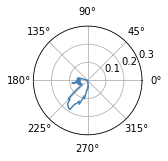

In [53]:
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

shrunk = list(theta[:len(time)])
for cell in range(0,N_ex,N_ex//8):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if len(idx[0]):
            angle = shrunk[idx[0][0]]
            angles.append(angle)
    av = np.average(angles)
    fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color = 'steelblue')
#     ax.plot(np.ones(3)*av,np.arange(0,.3,.1),color='darkgrey')
    ax.set_yticks([.1,.2,.3])


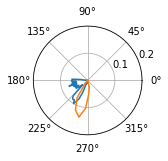

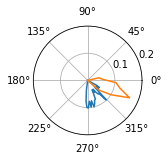

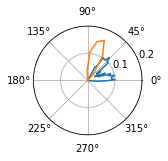

In [54]:
for cell in [0,45,90]:
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles1 = []
    angles2 = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//2:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles1.append(angle)
        else:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles2.append(angle)
    fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles1, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1)
    ax.set_yticks([.1,.2])
    hist, bin_edges = np.histogram(angles2, bins=np.arange(-np.pi,np.pi,np.pi/20))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/20))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1)
    ax.set_yticks([.1,.2])


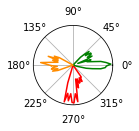

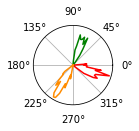

In [56]:
cells = [40,85,170]
colour = ['red','blue','green','orange']
colour = ['red','green','darkorange','orange']
fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})
for i,cell in enumerate(cells):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//3:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color=colour[i])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f'example_cells_early',format='svg')

fig, ax = plt.subplots(figsize=(2,2), subplot_kw={'projection': 'polar'})
for i,cell in enumerate(cells):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm > (sim_len//3)*2:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color=colour[i])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig(f'example_cells_late',format='svg')


In [22]:
# # allign measurement of most active cell to the frame time which will be used in the predNet

# predtm = pandas.read_csv(f'data/{file}_frames.csv')
# predtm = np.array(predtm['%time'])
# prediciton_times = (predtm-predtm[0])/1000000

In [23]:
# ev = sim.GetStatus(exc_spikes)[0]['events']
# t = ev['times']
# sp = ev['senders']

# T = prediciton_times[2:]

# modes = np.zeros(len(T))
# modes[:] = np.nan
# rates = np.zeros((N_ex,len(time)))
# for i in range(len(T)-1):
#     idx = (t>T[i]-30)*(t<T[i]+30)
#     lst = sp[np.where(idx)]
#     occurence_count = Counter(lst) 
#     active = occurence_count.keys()
#     for cell in active:
#         rates[cell-1,i] = occurence_count[cell]
#     mode = occurence_count.most_common(1)
#     if len(mode):
#         modes[i] = mode[0][0]
        
# step = (2*np.pi)/N_ex
# modes = (modes*step) - np.pi

In [24]:
# fig, ax = plt.subplots(1, 1,figsize=(10, 5),facecolor='w')
# ax.plot(T,modes,'.',label='estimate')
# ax.plot(time,theta[:len(time)],'.',label='odometry')
# plt.legend()
# hd_estimate = np.vstack([T,modes])
# np.save(f'{file}_ideo_estimate_byFrameTime.npy',hd_estimate)

In [25]:
# ev = sim.GetStatus(exc_spikes)[0]['events']
# t = ev['times']
# sp = ev['senders']

# PD = np.zeros((N_ex))
# shrunk = list(theta[:len(time)])
# for cell in range(0,N_ex):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if len(idx[0]):
#             angle = shrunk[idx[0][0]]
#             angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
#     bin_centers = np.append(bin_centers,bin_centers[0])
#     hist = np.append(hist,hist[0])
#     hist3 = np.append(hist3,hist3[0])
#     h1 = hist/hist3
#     PD[cell] = bin_centers[np.argmax(h1)]
    
# PD1 = np.zeros((N_ex))
# rng1 = np.zeros((N_ex))
# rng1[:] = np.nan
# for cell in range(0,N_ex):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if spktm < sim_len//3:
#             if len(idx[0]):
#                 angle = shrunk[idx[0][0]]
#                 angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
# #     bin_centers = np.append(bin_centers,bin_centers[0])
# #     hist = np.append(hist,hist[0])
# #     hist3 = np.append(hist3,hist3[0])
#     h1 = hist/hist3
#     PD1[cell] = bin_centers[np.argmax(h1)]
# #     plt.plot(bin_centers,h1,color = 'steelblue')
# #     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,.3,.1),color='darkgrey')

#     threshold_crossings = np.diff(h1 > 0.025, prepend=False)
# #     plt.plot(bin_centers,threshold_crossings, marker='o')

#     crossings = bin_centers[threshold_crossings]
#     if len(crossings) > 2:
#         crossings=crossings[1:]
#     if len(crossings) == 2:
#         if PD1[cell] > crossings[1] or PD1[cell] < crossings[0]:
#             rng1[cell] = crossings[0]+(2*np.pi)-crossings[-1]
#         else:
#             rng1[cell] = crossings[-1]-crossings[0]

# PD3 = np.zeros((N_ex))
# rng3 = np.zeros((N_ex))
# rng3[:] = np.nan
# for cell in range(0,N_ex):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if spktm > (sim_len//3)*2:
#             if len(idx[0]):
#                 angle = shrunk[idx[0][0]]
#                 angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
# #     bin_centers = np.append(bin_centers,bin_centers[0])
# #     hist = np.append(hist,hist[0])
# #     hist3 = np.append(hist3,hist3[0])
#     h1 = hist/hist3
#     PD3[cell] = bin_centers[np.argmax(h1)]
    
# #     plt.plot(bin_centers,h1,color = 'steelblue')
# #     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,.3,.1),color='darkgrey')
    
#     threshold_crossings = np.diff(h1 > 0.025, prepend=False)
# #     plt.plot(bin_centers,threshold_crossings, marker='o')

#     crossings = bin_centers[threshold_crossings]
#     if len(crossings) > 2:
#         crossings=crossings[1:]
#     if len(crossings) == 2:
#         if PD3[cell] > crossings[1] or PD3[cell] < crossings[0]:
#             rng3[cell] = crossings[0]+(2*np.pi)-crossings[-1]
#         else:
#             rng3[cell] = crossings[-1]-crossings[0]
            
# cell_data = {}
# cell_data['PD']=PD
# cell_data['PD1']=PD1
# cell_data['PD3']=PD3
# cell_data['range1']=rng1
# cell_data['range3']=rng1
# df = pandas.DataFrame(data=cell_data)
# df.to_csv(f'{file}_cellData.csv')
# print(df)
# plt.hist(rng1,bins=np.arange(0,np.pi,np.pi/20))

In [26]:
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

PD = np.zeros((N_ex))
shrunk = list(theta[:len(time)])
for cell in range(N_ex,N_ex*2):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if len(idx[0]):
            angle = shrunk[idx[0][0]]
            angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    PD[cell-N_ex] = bin_centers[np.argmax(h1)]
    
PD1 = np.zeros((N_ex))
rng1exc = np.zeros((N_ex))
rng1exc[:] = np.nan
for cell in range(1,N_ex):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
#     bin_centers = np.append(bin_centers,bin_centers[0])
#     hist = np.append(hist,hist[0])
#     hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    PD1[cell] = bin_centers[np.argmax(h1)]
#     plt.plot(bin_centers,h1,color = 'steelblue')
#     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,3),color='darkgrey')

    threshold_crossings = np.diff(h1 > 0.025, prepend=False)
#     plt.plot(bin_centers,threshold_crossings, marker='o')

    crossings = bin_centers[threshold_crossings]
    if len(crossings) > 2:
        crossings=crossings[1:]
    if len(crossings) == 2:
        if PD1[cell] > crossings[1] or PD1[cell] < crossings[0]:
            rng1exc[cell] = crossings[0]+(2*np.pi)-crossings[-1]
        else:
            rng1exc[cell] = crossings[-1]-crossings[0]

# PD3 = np.zeros((N_ex))
# rng3 = np.zeros((N_ex))
# rng3[:] = np.nan
# for cell in range(N_ex,N_ex*2):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if spktm > (sim_len//3)*2:
#             if len(idx[0]):
#                 angle = shrunk[idx[0][0]]
#                 angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
# #     bin_centers = np.append(bin_centers,bin_centers[0])
# #     hist = np.append(hist,hist[0])
# #     hist3 = np.append(hist3,hist3[0])
#     h1 = hist/hist3
#     PD3[cell] = bin_centers[np.argmax(h1)]
    
# #     plt.plot(bin_centers,h1,color = 'steelblue')
# #     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,.3,.1),color='darkgrey')
    
#     threshold_crossings = np.diff(h1 > 0.025, prepend=False)
# #     plt.plot(bin_centers,threshold_crossings, marker='o')

#     crossings = bin_centers[threshold_crossings]
#     if len(crossings) > 2:
#         crossings=crossings[1:]
#     if len(crossings) == 2:
#         if PD3[cell] > crossings[1] or PD3[cell] < crossings[0]:
#             rng3[cell] = crossings[0]+(2*np.pi)-crossings[-1]
#         else:
#             rng3[cell] = crossings[-1]-crossings[0]
            
# cell_data = {}
# # cell_data['PD']=PD
# cell_data['PD1']=PD1
# # cell_data['PD3']=PD3
# cell_data['range1']=rng1
# # cell_data['range3']=rng3
# df = pandas.DataFrame(data=cell_data)
# df.to_csv(f'{file}_cellData_EXC.csv')
# print(df)
# plt.hist(rng1,bins=np.arange(0,2*np.pi,np.pi/20))

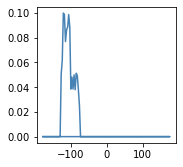

In [27]:
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

a = 30

shrunk = list(theta[:len(time)])
for cell in [a]:
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//3:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    av = np.average(angles)
    fig, ax = plt.subplots(figsize=(2.5,2.5)) #, subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers*(180/np.pi),h1,color = 'steelblue')
#     ax.plot(np.ones(3)*av,np.arange(0,.3,.1),color='darkgrey')
#     ax.set_yticks([.1,.2,.3])

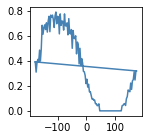

In [28]:
ev = sim.GetStatus(inh_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

shrunk = list(theta[:len(time)])
for cell in [a+N_ex]:
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//3:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    av = np.average(angles)
    fig, ax = plt.subplots(figsize=(2,2))#, subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers*(180/np.pi),h1,color = 'steelblue')
#     ax.plot(np.ones(3)*av,np.arange(0,.3,.1),color='darkgrey')

In [29]:
PD = np.zeros((N_ex))
shrunk = list(theta[:len(time)])
for cell in range(N_ex,N_ex*2):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if len(idx[0]):
            angle = shrunk[idx[0][0]]
            angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    PD[cell-N_ex] = bin_centers[np.argmax(h1)]
    
PD1 = np.zeros((N_ex))
rng1inh = np.zeros((N_ex))
rng1inh[:] = np.nan
for cell in range(N_ex,N_ex*2):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
#     bin_centers = np.append(bin_centers,bin_centers[0])
#     hist = np.append(hist,hist[0])
#     hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    PD1[cell-N_ex] = bin_centers[np.argmax(h1)]
#     plt.plot(bin_centers,h1,color = 'steelblue')
#     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,3),color='darkgrey')

    threshold_crossings = np.diff(h1 > 0.025, prepend=False)
#     plt.plot(bin_centers,threshold_crossings, marker='o')

    crossings = bin_centers[threshold_crossings]
    if len(crossings) > 2:
        crossings=crossings[1:]
    if len(crossings) == 2:
        if PD1[cell-N_ex] > crossings[1] or PD1[cell-N_ex] < crossings[0]:
            rng1inh[cell-N_ex] = crossings[0]+(2*np.pi)-crossings[-1]
        else:
            rng1inh[cell-N_ex] = crossings[-1]-crossings[0]

# PD3 = np.zeros((N_ex))
# rng3 = np.zeros((N_ex))
# rng3[:] = np.nan
# for cell in range(N_ex,N_ex*2):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if spktm > (sim_len//3)*2:
#             if len(idx[0]):
#                 angle = shrunk[idx[0][0]]
#                 angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
# #     bin_centers = np.append(bin_centers,bin_centers[0])
# #     hist = np.append(hist,hist[0])
# #     hist3 = np.append(hist3,hist3[0])
#     h1 = hist/hist3
#     PD3[cell] = bin_centers[np.argmax(h1)]
    
# #     plt.plot(bin_centers,h1,color = 'steelblue')
# #     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,.3,.1),color='darkgrey')
    
#     threshold_crossings = np.diff(h1 > 0.025, prepend=False)
# #     plt.plot(bin_centers,threshold_crossings, marker='o')

#     crossings = bin_centers[threshold_crossings]
#     if len(crossings) > 2:
#         crossings=crossings[1:]
#     if len(crossings) == 2:
#         if PD3[cell] > crossings[1] or PD3[cell] < crossings[0]:
#             rng3[cell] = crossings[0]+(2*np.pi)-crossings[-1]
#         else:
#             rng3[cell] = crossings[-1]-crossings[0]
            
# cell_data = {}
# # cell_data['PD']=PD
# cell_data['PD1']=PD1
# # cell_data['PD3']=PD3
# cell_data['range1']=rng1
# # cell_data['range3']=rng3
# df = pandas.DataFrame(data=cell_data)
# df.to_csv(f'{file}_cellData_INH.csv')
# print(df)
# plt.hist(rng1,bins=np.arange(0,2*np.pi,np.pi/20))

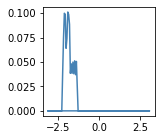

In [30]:
ev = sim.GetStatus(conj_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

shrunk = list(theta[:len(time)])
for cell in [a+N_ex*2]:
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len//3:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    av = np.average(angles)
    fig, ax = plt.subplots(figsize=(2,2))#, subplot_kw={'projection': 'polar'})
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    ax.plot(bin_centers,h1,color = 'steelblue')
#     ax.plot(np.ones(3)*av,np.arange(0,.3,.1),color='darkgrey')
#     ax.set_yticks([.1,.2,.3])
    

In [31]:
PD = np.zeros((N_ex))
shrunk = list(theta[:len(time)])
for cell in range(N_ex,N_ex*2):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if len(idx[0]):
            angle = shrunk[idx[0][0]]
            angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
    bin_centers = np.append(bin_centers,bin_centers[0])
    hist = np.append(hist,hist[0])
    hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    PD[cell-N_ex] = bin_centers[np.argmax(h1)]
    
PD1 = np.zeros((N_ex))
rng1conj = np.zeros((N_ex))
rng1conj[:] = np.nan
for cell in range(N_ex*2,N_ex*3):
    spktms = ((t[sp == cell+1]//20)*20).astype(int)
    angles = []
    for spktm in spktms:
        idx = np.where(time == spktm)
        if spktm < sim_len:
            if len(idx[0]):
                angle = shrunk[idx[0][0]]
                angles.append(angle)
    hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
    hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
    bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
#     bin_centers = np.append(bin_centers,bin_centers[0])
#     hist = np.append(hist,hist[0])
#     hist3 = np.append(hist3,hist3[0])
    h1 = hist/hist3
    PD1[cell-(N_ex*2)] = bin_centers[np.argmax(h1)]
#     plt.plot(bin_centers,h1,color = 'steelblue')
#     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,3),color='darkgrey')

    threshold_crossings = np.diff(h1 > 0.025, prepend=False)
#     plt.plot(bin_centers,threshold_crossings, marker='o')

    crossings = bin_centers[threshold_crossings]
    if len(crossings) > 2:
        crossings=crossings[1:]
    if len(crossings) == 2:
        if PD1[cell-(N_ex*2)] > crossings[1] or PD1[cell-(N_ex*2)] < crossings[0]:
            rng1conj[cell-(N_ex*2)] = crossings[0]+(2*np.pi)-crossings[-1]
        else:
            rng1conj[cell-(N_ex*2)] = crossings[-1]-crossings[0]

# PD3 = np.zeros((N_ex))
# rng3 = np.zeros((N_ex))
# rng3[:] = np.nan
# for cell in range(N_ex,N_ex*2):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if spktm > (sim_len//3)*2:
#             if len(idx[0]):
#                 angle = shrunk[idx[0][0]]
#                 angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-np.pi,np.pi,np.pi/60))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
# #     bin_centers = np.append(bin_centers,bin_centers[0])
# #     hist = np.append(hist,hist[0])
# #     hist3 = np.append(hist3,hist3[0])
#     h1 = hist/hist3
#     PD3[cell] = bin_centers[np.argmax(h1)]
    
# #     plt.plot(bin_centers,h1,color = 'steelblue')
# #     plt.plot(np.ones(3)*bin_centers[np.argmax(h1)],np.arange(0,.3,.1),color='darkgrey')
    
#     threshold_crossings = np.diff(h1 > 0.025, prepend=False)
# #     plt.plot(bin_centers,threshold_crossings, marker='o')

#     crossings = bin_centers[threshold_crossings]
#     if len(crossings) > 2:
#         crossings=crossings[1:]
#     if len(crossings) == 2:
#         if PD3[cell] > crossings[1] or PD3[cell] < crossings[0]:
#             rng3[cell] = crossings[0]+(2*np.pi)-crossings[-1]
#         else:
#             rng3[cell] = crossings[-1]-crossings[0]
            
# cell_data = {}
# # cell_data['PD']=PD
# cell_data['PD1']=PD1
# # cell_data['PD3']=PD3
# cell_data['range1']=rng1
# # cell_data['range3']=rng3
# df = pandas.DataFrame(data=cell_data)
# df.to_csv(f'{file}_cellData_conj.csv')
# print(df)
# plt.hist(rng1,bins=np.arange(0,2*np.pi,np.pi/20))

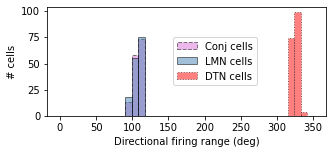

In [46]:
plt.figure(figsize=(5,2))
plt.xlabel('Directional firing range (deg)')
plt.ylabel('# cells')
plt.hist(rng1conj*(180/np.pi),bins=np.arange(0,360,180/20),ls='dashed', lw=1, color = 'orchid', alpha = 0.5, edgecolor='black',label='Conj cells')
plt.hist(rng1exc*(180/np.pi),bins=np.arange(0,360,180/20), lw=1, color = 'steelblue', alpha = 0.5, edgecolor='black',label='LMN cells')
plt.hist(rng1inh*(180/np.pi),bins=np.arange(0,360,180/20),ls='dotted', lw=1, color = 'red', alpha = 0.5, edgecolor='black',label='DTN cells')
plt.legend(loc='center', bbox_to_anchor=(0.5, 0., 0.2, 1), borderaxespad=2.)
plt.savefig('dir_range',bbox_inches="tight",format='svg')

In [33]:
excAv = np.around(np.nanmean(rng1exc),3)
excSE = np.around(np.nanstd(rng1exc)/np.sqrt(len(rng1exc)),3)
print(f'LMN average directional firing range = {excAv} +/- {excSE} radians')
inhAv = np.around(np.nanmean(rng1inh),3)
inhSE = np.around(np.nanstd(rng1inh)/np.sqrt(len(rng1inh)),3)
print(f'DTN average directional firing range = {inhAv} +/- {inhSE} radians')
conjAv = np.around(np.nanmean(rng1conj),3)
conjSE = np.around(np.nanstd(rng1conj)/np.sqrt(len(rng1conj)),3)
print(f'Conj average directional firing range = {conjAv} +/- {conjSE} radians')


In [34]:
# ## AHV

# # PD = np.zeros((N_ex))
# shrunk = vel[:len(time)]
# for cell in range(N_ex*2+89,(N_ex*2)+90):
#     spktms = ((t[sp == cell+1]//20)*20).astype(int)
#     angles = []
#     for spktm in spktms:
#         idx = np.where(time == spktm)
#         if len(idx[0]):
#             angle = shrunk[idx[0][0]]
#             angles.append(angle)
#     hist, bin_edges = np.histogram(angles, bins=np.arange(-0.02,0.02,0.0005))
#     hist3, _ = np.histogram(shrunk, bins=np.arange(-0.02,0.02,0.0005))
#     bin_centers = bin_edges[:-1]+(np.diff(bin_edges)[0])/2
#     h1 = hist
# #     PD[cell-N_ex] = bin_centers[np.argmax(h1)]

#     plt.plot(bin_centers,h1,'.',color = 'steelblue')
# plt.xlabel('AHV (degrees/s)')
# plt.ylabel('Firing rate (spikes/s)')